# Results

### Check for errors

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-06-14 07:52:58.125739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 07:52:58.651510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
vars_list = [10, 20, 30, 40, 50]
exp_folder = 'hypersearch/pg_solver'

errors = {}
for num_vars in vars_list:
    # Get path for every hyperparameter search
    folder_n = os.path.join(exp_folder, f'{num_vars:04d}')
    folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
    folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
    folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

    # Count errors for every hyperparameter search
    errors[f'n={num_vars}'] = {}
    errors[f'n={num_vars}']['num_errors'] = 0
    for i, search_path in enumerate(folder_assumption):
        
        # Restore the GridSearch object
        restored_tuner = tune.Tuner.restore(path=search_path,
                                            trainable=pg_solver,
                                            resume_unfinished=False,
                                            resume_errored=False,
                                            restart_errored=False)
        results = restored_tuner.get_results()
                
        if results.num_errors > 0:
            #print(f'n={num_vars}, {search_path}, errors = {results.num_errors}, terminated = {results.num_terminated}')

            errors[f'n={num_vars}']['num_errors'] += 1
            errors[f'n={num_vars}'][f'{i}'] = f'path: {search_path}, errors: {results.errors}, num_errors: {results.num_errors},  terminated: {results.num_terminated}'

    errors[f'n={num_vars}']['num_searchs'] = len(folder_assumption)
    #print(f'Total errors for n = {num_vars}: {errors}. Total searchs: {len(folder_assumption)}\n')

In [3]:
# Print keys and values
for key, value in errors.items():
    print(key)
    print(value)
    print('\n')

n=10
{'num_errors': 0, 'num_searchs': 120}


n=20
{'num_errors': 0, 'num_searchs': 120}


n=30
{'num_errors': 0, 'num_searchs': 120}


n=40
{'num_errors': 0, 'num_searchs': 120}


n=50
{'num_errors': 0, 'num_searchs': 120}




# Results

### Why it is important to load dataframe instead of get_best_results

In [ ]:
# Load best results
exp_path = 'hypersearch/pg_solver/0030/0135/rand_n=0030_k=03_m=0135_i=01/arch'

# Restore the GridSearch object
restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver,
                                    resume_unfinished=False,
                                    resume_errored=False,
                                    restart_errored=False)

results = restored_tuner.get_results()

# Check if there have been errors
if results.errors:
    print("Errors reported.")
else:
    print("No errors reported.")

# Get best trial
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='last').metrics['num_sat_eval'])
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='all').metrics['num_sat_eval'])
print(results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max())

/tmp/ipykernel_1873509/4211334018.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 95), palette=color_pallete, marker='o')
/tmp/ipykernel_1873509/4211334018.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 95), palette=color_pallete, marker='o')
/tmp/ipykernel_1873509/4211334018.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 95), palette=color_pallete, marker='o')
/tmp/ipykernel_1873509/4211334018.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 95), palette=color_pallete, marker='

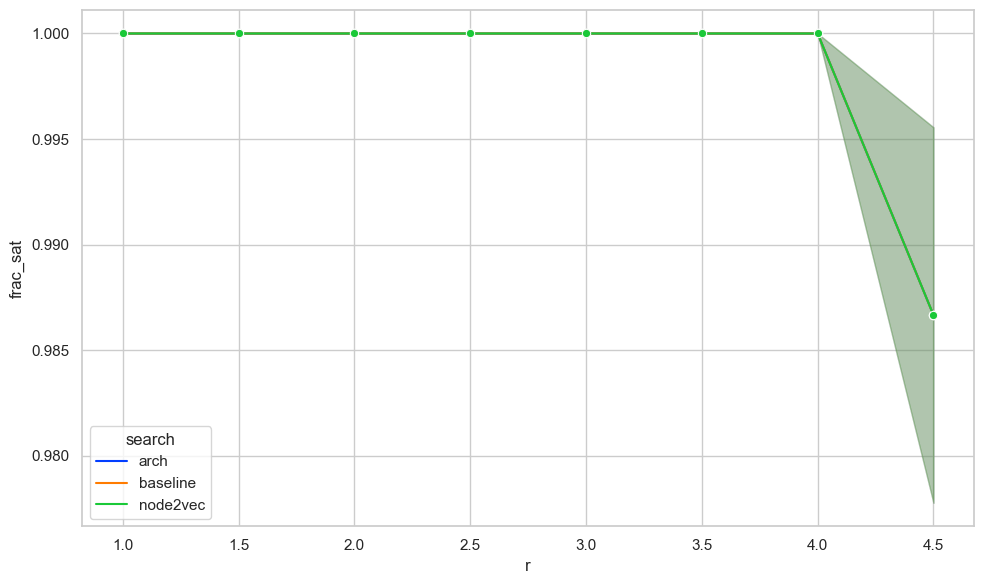

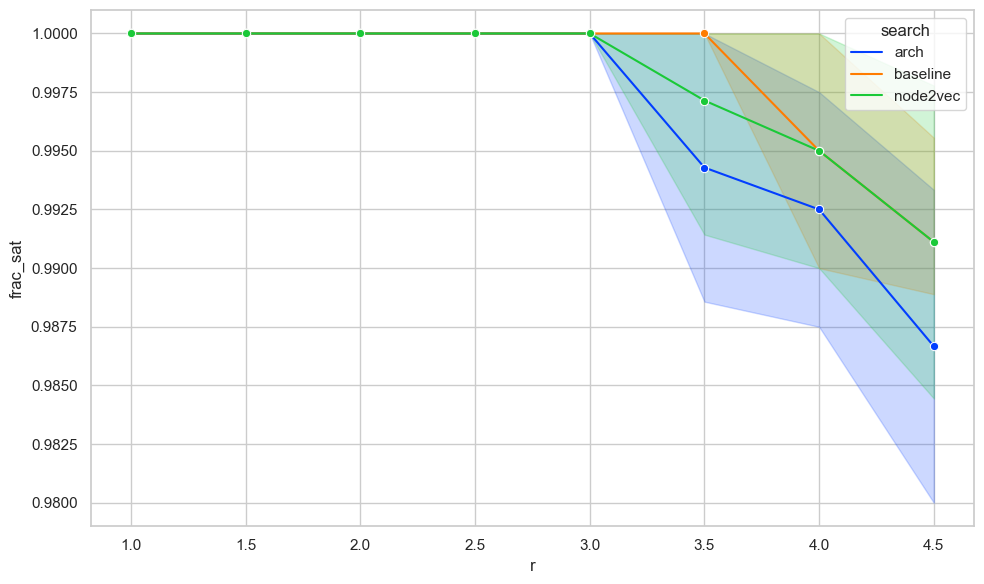

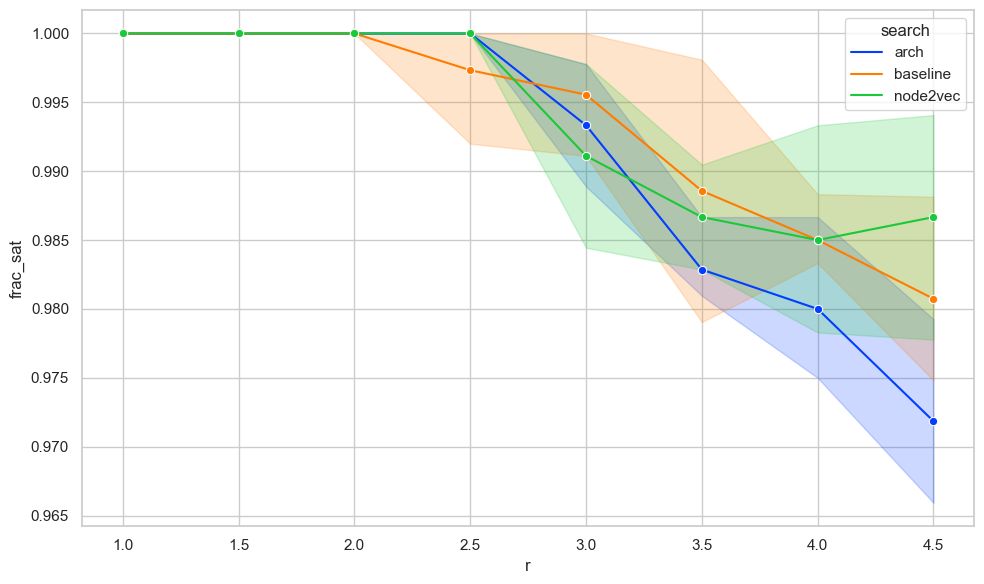

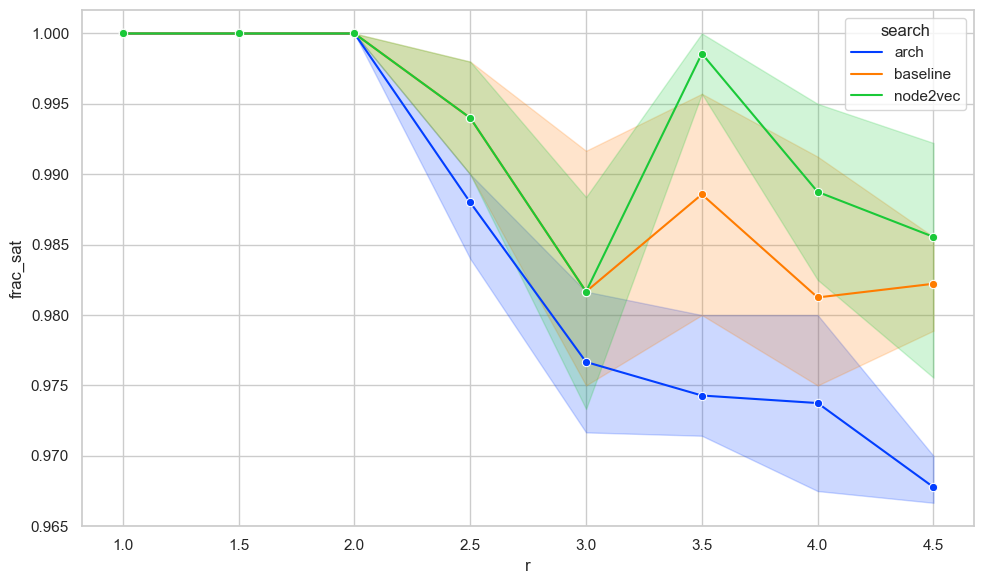

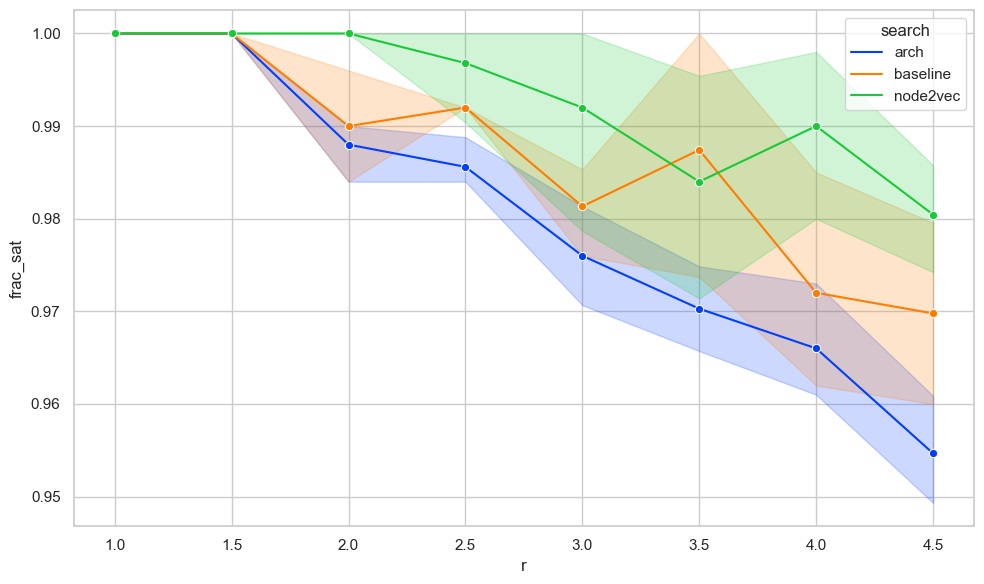

In [5]:
for num_vars in [10, 20, 30, 40, 50]:
    exp_folder = 'hypersearch/pg_solver'

    # Get path for every hyperparameter search
    folder_n = os.path.join(exp_folder, f'{num_vars:04d}')
    folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
    folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
    folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

    # Build dictionary with best result for every hyperparameter search
    dic_results = {}

    for i, search_path in enumerate(folder_assumption):
        # Create experiment id
        split_path = search_path.split("/")
        n = split_path[2]
        m = split_path[3]
        i = split_path[4][-2:]
        s = split_path[5]
        exp_id = f'{n}/{m}/{i}/{s}'
        
        # Restore the GridSearch object
        restored_tuner = tune.Tuner.restore(path=search_path,
                                            trainable=pg_solver,
                                            resume_unfinished=False,
                                            resume_errored=False,
                                            restart_errored=False)
        results = restored_tuner.get_results()
        
        # Get best trial
        max_val = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max()
        # Update dict
        dic_results[exp_id] = [int(n), int(m), int(i), s, max_val]

    # Create dataframe
    columns = ['n', 'm', 'i', 'search', 'num_sat_eval']
    df = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
    df.insert(2, 'r', df['m'] / df['n'])
    df.insert(6, 'frac_sat', df['num_sat_eval'] / df['m'])


    plt.figure(figsize = (10,6))
    sns.set_theme(style="whitegrid", palette="bright")
    color_pallete = sns.color_palette("bright")

    sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 95), palette=color_pallete, marker='o')
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'img/frac_sat_{num_vars}.png', dpi=300)

In [ ]:
df

In [ ]:
# Unique values of num_sat_eval when r = 4.5
df[df['r'] == 4.5]['num_sat_eval']

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [ ]:
# Unique values of num_sat_eval when r = 4.5
df[df['r'] == 4.0]['num_sat_eval']

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1873509/3066185742.py:48: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 99), palette=color_pallete, marker='o')


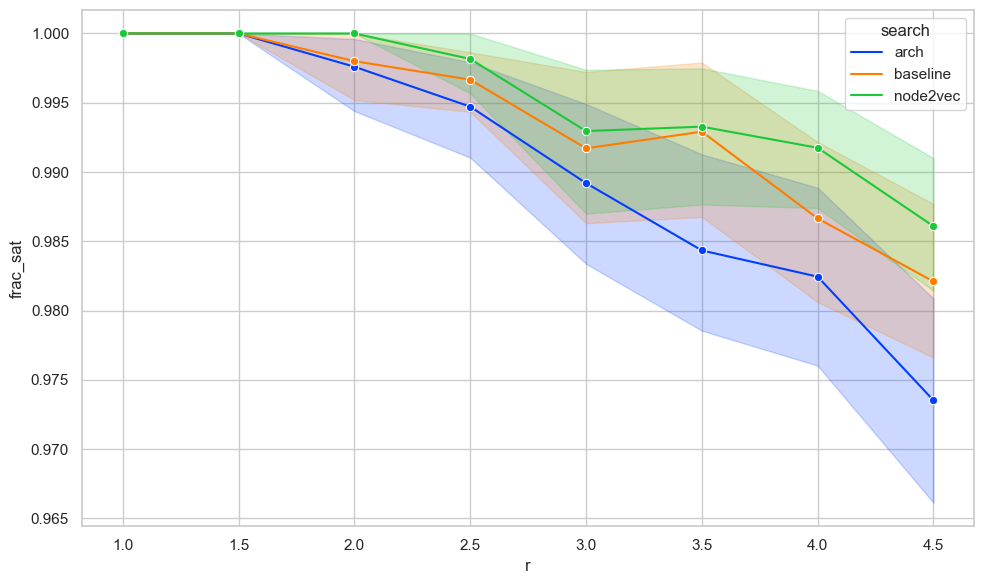

In [7]:
exp_folder = 'hypersearch/pg_solver'

# Find folders (for each n) inside exp_folder
folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])

dic_results = {}

# Get path for every hyperparameter search
for folder_n in folders_n:
    folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
    folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
    folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

    # Build dictionary with best result for every hyperparameter search
    for i, search_path in enumerate(folder_assumption):
        # Create experiment id
        split_path = search_path.split("/")
        n = split_path[2]
        m = split_path[3]
        i = split_path[4][-2:]
        s = split_path[5]
        exp_id = f'{n}/{m}/{i}/{s}'
        
        # Restore the GridSearch object
        restored_tuner = tune.Tuner.restore(path=search_path,
                                            trainable=pg_solver,
                                            resume_unfinished=False,
                                            resume_errored=False,
                                            restart_errored=False)
        results = restored_tuner.get_results()
        
        # Get best trial
        max_val = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max()
        # Update dict
        dic_results[exp_id] = [int(n), int(m), int(i), s, max_val]

# Create dataframe
columns = ['n', 'm', 'i', 'search', 'num_sat_eval']
df = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
df.insert(2, 'r', df['m'] / df['n'])
df.insert(6, 'frac_sat', df['num_sat_eval'] / df['m'])


plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
#color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar=('ci', 99), palette=color_pallete, marker='o')
plt.tight_layout()
#plt.show()
plt.savefig(f'img/frac_sat.png', dpi=300)

In [ ]:

df

In [9]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

l = sorted(l, reverse=True)

l

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]